In [1]:
import sys
sys.path.append('C:/maldb/python/mlp/')

import tensorflow as tf
from tensorflow import keras

import numpy as np
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from ionizer import *

In [2]:
#METHODS FOR VECTORZING DATA

#When we shuffle our training and test arrays, we need to shuffle them in unison so that the indices in the labels array line up with their corresponding peptide in the training array.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def aa_to_int(char):
    aa_map = {
    'A': 0,
    'C': 1,
    'D': 2,
    'E': 3,
    'F': 4,
    'G': 5,
    'H': 6,
    'I': 7,
    'K': 8,
    'L': 9,
    'M': 10,
    'N': 11,
    'P': 12,
    'Q': 13,
    'R': 14,
    'S': 15,
    'T': 16,
    'V': 17,
    'W': 18,
    'Y': 19
}
    
    return(aa_map[char])

def pad_peptide(arr, max_dim=64):
    return np.pad(arr, [(0, max_dim - arr.shape[0]), (0, 0)])

def one_hot_padded_sequence(seq):
    chars = []
    chars[:] = seq
    aaints = np.vectorize(aa_to_int)(chars)
    one_hot = keras.utils.to_categorical(aaints, num_classes=20)
    return pad_peptide(one_hot)
    
def vectorize_sequences(seqs):
    vectorized = []
    for seq in seqs:
        vectorized.append(one_hot_padded_sequence(seq))
    return np.array(vectorized)

In [21]:
#Get the data from the excel sheet, calculate feature vectors for each entry (row) using ionizers.py
train_data, train_seqs, train_labels = get_ionizer_training_data('C:/maldb/python/mlp/data/ionizers.csv')

#Let's vectorize our sequences
x_train_seqs = vectorize_sequences(train_seqs)
y_train = train_labels.astype('float32')

print(x_train_seqs[0])

#split = round(0.50 * num_samples) #makes an 85/15 split of the dataset

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [11]:
#We should randomly shuffle our data before splitting it into training and test sets
#The peptides were deposited into the array on a per-protein basis, so each protein may have a specific AA composition, properties etc.
#Thus, if the first 85% of our data were soluble proteins, and the last 15% were membrane proteins, we are likely to have poor prediction since our model never saw/had a chance to learn on membrane peptides!

#Shuffle!
#Shuffling will be taken care of if you use the validation_split KWARG in model.fit method.
#x_train_seqs, y_train_shuffled = unison_shuffled_copies(x_train_seqs, y_train)

#Lets build a 1D convolutional model
from keras import models
from keras import layers

cmodel = models.Sequential()
cmodel.add(layers.Conv1D(1, kernel_size=12, activation="relu", input_shape=(64,20)))
cmodel.add(layers.MaxPooling1D(8))
cmodel.add(layers.Conv1D(1, kernel_size=6, activation="relu"))
cmodel.add(layers.GlobalMaxPooling1D())
cmodel.add(layers.Dense(1, activation="sigmoid"))

cmodel.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
    ],
)
epochs = 1000
e = range(1, epochs + 1)
history = cmodel.fit(
    x_train_seqs,
    y_train,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/1000
17/17 [==============================] - 1s 19ms/step - loss: 0.7215 - binary_accuracy: 0.4041 - val_loss: 0.7104 - val_binary_accuracy: 0.3958
Epoch 2/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.7054 - binary_accuracy: 0.3963 - val_loss: 0.6988 - val_binary_accuracy: 0.4173
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.6911 - binary_accuracy: 0.4314 - val_loss: 0.6899 - val_binary_accuracy: 0.4671
Epoch 4/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.6838 - binary_accuracy: 0.4853 - val_loss: 0.6848 - val_binary_accuracy: 0.5203
Epoch 5/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.6782 - binary_accuracy: 0.5335 - val_loss: 0.6819 - val_binary_accuracy: 0.5564
Epoch 6/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.6749 - binary_accuracy: 0.5658 - val_loss: 0.6793 - val_binary_accuracy: 0.5834
Epoch 7/1000
17/17 [==============================] - 0s 3ms/st

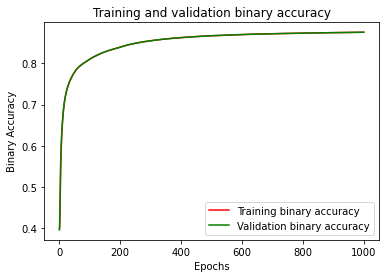

In [12]:
history_dict = history.history
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
plt.plot(e, acc_values, 'r-', label='Training binary accuracy')
plt.plot(e, val_acc_values, 'g-', label='Validation binary accuracy')
plt.title('Training and validation binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

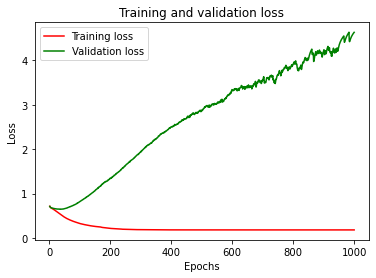

In [13]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
plt.plot(e, loss, 'r-', label='Training loss')
plt.plot(e, val_loss, 'g-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(array([457.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   3., 203.]),
 array([0.07294828, 0.09148932, 0.11003035, 0.12857138, 0.14711241,
        0.16565345, 0.18419449, 0.20273551, 0.22127655, 0.23981759,
        0.25835863, 0.27689967, 0.2954407 , 0.3139817 , 0.33252275,
        0.3510638 , 0.36960483, 0.38814586, 0.4066869 , 0.42522794,
        0.44376898, 0.46231   , 0.48085102, 0.49939206, 0.51793313,
        0.5364741 , 0.55501515, 0.5735562 , 0.5920972 , 0.61063826,
        0.6291793 , 0.64772034, 0.6662614 , 0.6848024 , 0.70334345,
        0.7218845 , 0.7404255 , 0.75896657, 0.7775076 , 0.79604864,
        0.8145897 , 0.8331307 , 0.8516717 , 0.87021273, 0.8887538 ,
        0.9072948 , 0.92583585, 0.9443769 , 0.

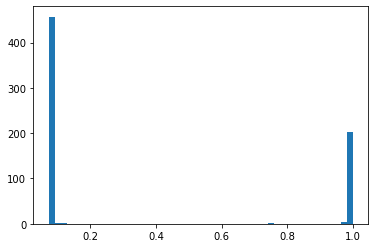

In [20]:
plt.hist(cmodel.predict(x_train_seqs), bins=50)